### Data science Internship 
#### Task 2 : Building an algorithm for predicting the changes in inflation or dollar exchange rate
#### Prepared by: Assylnur Lesken

In [2]:
#Import libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

# For scraping
import requests
from bs4 import BeautifulSoup
import urllib.request

import  docx
from pdfminer.pdfparser import PDFParser
from pdfminer.pdfdocument import PDFDocument
from pdfminer.pdfpage import PDFPage
import pdfminer

# Text
import re
import stanza
import pymorphy2
import nltk
from nltk.corpus import stopwords
from collections import Counter

# Regression
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

# NN
import math
import torch
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, Dropout

## 1. Collecting Dataset

#### 1.1 Scraping

The dataset for independent variable scraped from the website https://nationalbank.kz, using BeautifulSoup python library. A total of 268 files should be downloaded from various web pages

In [2]:
files = dict()
for i in range(1, 29):
    html_text = requests.get('https://nationalbank.kz/ru/news/doklady-i-vystupleniya?page='+str(i)).text
    soup = BeautifulSoup(html_text, 'lxml')
    links = soup.find_all('a', class_="posts-files__icon-wrap")
    time = soup.find_all('time')
    title = soup.find_all('div', class_="posts-files__title")
    for link in links:
        files[('https://nationalbank.kz' + link.get('href'))] = [link.get('title'), 
                                                                 title[links.index(link)].find('a').text.replace('  ', '').replace('\n', ''),
                                                                 time[links.index(link)].get('datetime')]

In [3]:
def download_file(url):
    filename = './pdf2/'+ url.split('/')[-1]
    try:
        response = urllib.request.urlopen(url)    
    except urllib.error.URLError as e:
        print(url, 'not downloaded')
        return  
    
    filename +='.'+files[url][0]
    file = open(filename, 'wb')
    file_names.append(filename)
    file.write(response.read())
    file.close()
    
file_names = list()
for i in files:
    download_file(i)

In [4]:
def getText(filename):
    
    if filename.split('.')[-1]=='pdf':
        text = pdfminer.high_level.extract_text(filename)
        return text.replace('\n', '')
    else:
        doc = docx.Document(filename)
        fullText = []
        for para in doc.paragraphs:
            fullText.append(para.text)
        return '\n'.join(fullText).replace('\n', '')
    
texts = list()
for i in file_names:
    texts.append(getText(i))

In [35]:
df = pd.DataFrame()
df['title'] = [i[1] for i in list(files.values())]
df['text'] = texts
df['date'] = pd.to_datetime([i[2] for i in list(files.values())])
df['year'] = df.date.dt.year
df['month'] = df.date.dt.month

df.to_csv('data3.csv')
display(df.head())
print(df.shape)

,title,text,date,year,month
0,Комментарии заместителя директора департамента...,Комментарии заместителя директора Департамент...,2022-06-24,2022,6
1,Основные тезисы заместителя Председателя Нацио...,Основные тезисы заместителя Председателя Наци...,2022-06-21,2022,6
2,Комментарий начальника управления мониторинга ...,Комментарий начальника управления мониторинга...,2022-06-16,2022,6
3,Доклад НБ РК на пленарном заседании Сената Пар...,Доклад НБ РК на пленарном заседа...,2022-06-16,2022,6
4,Доклад НБ РК на заседании Правительства РК «Об...,Доклад НБ РК на заседании Правительства РК «Об...,2022-06-14,2022,6


(268, 5)


#### 1.2 Filtering text
For tokenization and lemmatization text I use the library Stanza. For stop words I downloaded them from nltk.corpus, and added some own words to list. 

In [ ]:
stanza.download('ru')
nlp = stanza.Pipeline(lang='ru', processors='tokenize,ner,lemma')
nltk.download('stopwords')

In [ ]:
# Stopwords
stop_words = set(stopwords.words('russian'))
stpwrd = ["«", '»', '!', ':', '.',  '”', '“','...',  '-', '–', '?', '.', "национальный", "банк", "это", 
          "который", "также", "наш", "мочь", "являться", "год", ")","(",
         'комментарий', 'доклад',' тезис' ,'г ', 'всё', 'стать', 'п', 'поэтому', 'данный', 'торг', 'образ',
         'газета', 'департамент',' управление', 'заявление',
          'иметь', 'несмотря','п', 'очень', 'вода', 'дуть', 'кликушествовать', 'оман', 
          'нб', 'рк', 'нбрк', 'тезис', 'из-за'
         ]
for i in stpwrd:
    stop_words.add(i)

In [ ]:
# function returns filtered text
def filter_tokens(tokens):
    filtered_tokens = []
    for token in tokens:
        if token not in stop_words and len(token)>2:
            filtered_tokens.append(token)
    return filtered_tokens

filtered_text =  []
for txt in df.text:
    
#   Remove URLs from text
    txt = re.sub(r'http\S+', '', txt)
    txt = re.sub(r'www\S+', '', txt)
    
#   tokenization and lemmatization
    doc = nlp(txt)
    norm_form  = [word.lemma.lower() for sent in doc.sentences for word in sent.words]
    y = [re.split('[^а-яА-Яa-zA-Z]',i.lower()) for i in  norm_form]
    y = ([' '.join([j for j in i if j!='']) for i in y ])
    
#   Removing stopwords
    filtered_text.append([i for i in filter_tokens(y ) if i!=''])
    
    
df['filtered_text'] = [' '.join(i)for i in filtered_text]

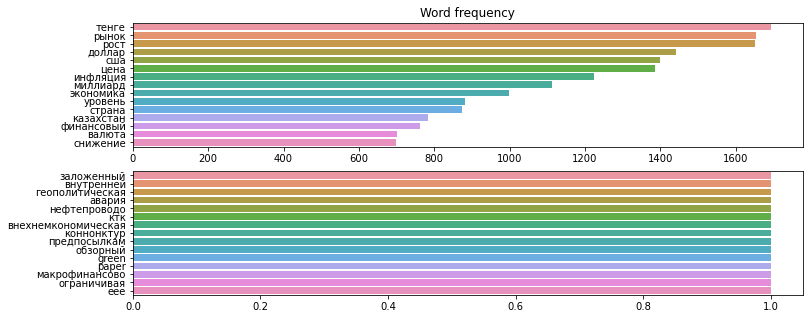

In [111]:
# Plot word frequency distribution
words = []
for i in (dd.filtered_text.values):
    wor = i.split(' ')
    for j in wor:   
        words.append(j)
        
c = Counter(words)
most = c.most_common()
x, y= [], []
x1, y1= [], []

for word,count in most[:15]:
        x.append(word)
        y.append(count)
        
for word,count in most[-15:]:
        x1.append(word)
        y1.append(count)  
        
fig, ax = plt.subplots(nrows=2, figsize=(12,5))
ax[0].set(title='Word frequency')
sns.barplot(x=y,y=x, ax=ax[0])
sns.barplot(x=y1,y=x1, ax=ax[1])
plt.show()


From the histogram above, you can see that some words occur in our text more than 1600 times, but some of them occur only once. Therefore I just kept the ones that appear more than 150 times and less than 1000:

In [23]:
# leave those that occur more than 150 and less than 1000 times throughout the text.
words =[]
for i in most:
    if i[1]>150 and i[1]<1000:
        words.append(i)

def filter_tokens2(tokens):
    filtered_tokens = []
    for token in tokens:
        if token in [i[0] for i in words]:
            filtered_tokens.append(token)
    return filtered_tokens

filtered_text2 = []
for i in df.filtered_text:
    wrds = i.split(' ')
    filtered_text2.append([i for i in filter_tokens2(wrds) if i!=''])
    
    
df['filtered_text2'] = [' '.join(i)for i in filtered_text2]

The remaining words were then summed by the year and month of the publication date,  then TF-IDF was used to vectorize them. As a result,  a vector with a size of 198 was obtained for each document:

In [68]:
#  summarize texts by year and month of published date
dd = df[['year', 'month', 'filtered_text2']].groupby(['year', 'month'], as_index=False).sum()
display(dd.head())
print(dd.shape)

,year,month,filtered_text2
0,2015,2,время февраль глава страна время привести новы...
1,2015,5,нацбанк внутренний инфляционный перспектива ин...
2,2015,9,нацбанк инфляционный программа экономический в...
3,2015,10,нацбанк должен курс бизнес решение прошлый сит...
4,2016,3,нацбанк казахстан россия политика страна казах...


(48, 3)


In [116]:
vectorizer = TfidfVectorizer()
tfidf_mat = vectorizer.fit_transform(dd.filtered_text2)

dd['vector'] = [i for i in tfidf_mat.toarray()]
dd.vector.values[0].shape

(198,)

## 2. Picking the target value

The target values are changes in inflation and the dollar exchange rate by months.

Information on changes in inflation was downloaded from the website https://fin-plus.ru/info/inflation_index/kazakhstan/. 

Information about dollar exchange rate was downloaded from the official website of the National Bank of Kazakhstan. 

In [26]:
inflation = pd.read_excel('inflation2.xlsx')
inflation.columns=['year', 1,2,3,4,5,6,7,8,9,10,11,12, 'total']

course = pd.read_excel('courses.xlsx')
course['year'] = course.Date.apply(lambda x: int(x.split('.')[-1]))
course['month'] = course.Date.apply(lambda x: int(x.split('.')[1]))
cs = course[['year','month', 'USD']].groupby(by=['year','month'], as_index=False).mean()

I collected vectors in the range of half a year and took inflation and dollar exchange rate of the next month of the range as the target value. As a consequence, a dataframe containing 56 records was produced; the vector size for each record is 1188(198*6): 

In [28]:
def find_inflation(year, month, l):
    month += l
    if month>12:
        month -= 12
        year +=1
    try:
        return inflation[inflation.year == year].loc[:, month].values[0]
    except:
        return np.nan
    
def find_course(year, month, l):
    month += l
    if month>12:
        month -= 12
        year +=1
    try:
        return cs[(cs.year == year)&(cs.month == month)].USD.values[0]
    except:
        return np.nan

In [34]:
df2 = pd.DataFrame()
for y in dd.year.unique():
    for m in range(1,8):
        months_range = [j for j in range(m, m+6)]
        range_m = str(months_range[0])+'-'+str(months_range[-1])

        
        d = dd[(dd.year==y)&(dd.month.isin(months_range))].loc[:45]
        inf =  find_inflation(y, months_range[-1], 1)
        crs = find_course(y, months_range[-1], 1)
        vectors = list()

        for i in months_range:
            if i in d.month.values:
                vectors.append(list(d[d.month==i]['vector'].values[0]))
            else:
                vectors.append(list(np.zeros(198)))

        if len(df2)==0:
            df2 = pd.DataFrame({'year':[int(y)],
                                'month range':[range_m],
                                'months':[d.month.values],
                                'vector': [vectors] ,
                                'inflation':[inf],
                                'USD': [crs]
                               })
        else:
            df2.loc[len(df2.index)] = [int(y),range_m, d.month.values, vectors, inf, crs] 
            


df2.to_csv('data4.csv')
display(df2.head())
print(df2.shape)

,year,month range,months,vector,inflation,USD
0,2015,1-6,"[2, 5]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.1,186.759677
1,2015,2-7,"[2, 5]","[[0.0, 0.0, 0.0, 0.0, 0.019892110175782046, 0....",0.3,206.988710
2,2015,3-8,[5],"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1.0,258.336667
3,2015,4-9,"[5, 9]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",5.2,275.458387
4,2015,5-10,"[5, 9, 10]","[[0.0, 0.028069912810058183, 0.010375634641849...",3.7,302.882333


(56, 6)


## 3. Regression

**Dependent Variable:** changes in inflation , dollar exchange rate

**Independent Variable:** TF-IDF vector of text.

I took month ranges "1-6," "2-7," "3-8," "4-9," and "5-10" for the train set and the remainder for the test set.

In [56]:
from sklearn.preprocessing import Normalizer
norm = Normalizer().fit([df2.USD.loc[:49].values])
df2['scale']=list(norm.transform([df2.USD.loc[:49].values])[0])+[np.nan,np.nan,np.nan,np.nan,np.nan,np.nan]

x = ['1-6', '2-7', '3-8', '4-9', '5-10']
train = df2[df2['month range'].isin(x)].loc[:49]
test  = df2[~df2['month range'].isin(x)].loc[:49]

X_train= train.vector
y_train = train.inflation
y_train2 = train.scale

X_test= test.vector
y_test = test.inflation
y_test2 = test.scale

In [58]:
X_train_shaped = np.array([np.array(i).flatten() for i in X_train ], dtype=float)
X_test_shaped = np.array([np.array(i).flatten() for i in X_test ], dtype=float)

In [61]:
def print_evaluate(true, predicted):  
    r2_square = metrics.r2_score(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    mae = metrics.mean_absolute_error(true, predicted)

    print('R-squared:', np.round(r2_square,5))
    print('MSE:', np.round(mse,3))
    print('RMSE:', np.round(rmse,3))
    print('MAE:', np.round(mae,3))
    
    return {'r2':r2_square , 'mse': mse, 'rmse':   rmse, 'mae' : mae }



# The function saves results of model
m, r_r2, r_mse, r_rmse, r_mae, s_r2, s_mse, s_rmse, s_mae= [],[],[],[],[],[],[],[],[]

def save_results(name, r, s, i=0,new=False):
    if new:
        m.append([])
        r_r2.append([])
        r_mse.append([])
        r_rmse.append([])
        r_mae.append([])
        
        s_r2.append([])
        s_mse.append([])
        s_rmse.append([])
        s_mae.append([])

    m[i].append(name)
    r_r2[i].append(r['r2'])
    r_mse[i].append(r['mse'])
    r_rmse[i].append(r['rmse'])
    r_mae[i].append(r['mae'])

    s_r2[i].append(s['r2'])
    s_mse[i].append(s['mse'])
    s_rmse[i].append(s['rmse'])
    s_mae[i].append(s['mae'])
    
    

### 3.1 target = inflation

#### XGBoost Regressor, GridSearchCV

In [58]:
# XGBoost Regressor
model = XGBRegressor()
model.fit(X_train_shaped, y_train.values)

print('Train:') 
r = print_evaluate(y_train, model.predict(X_train_shaped))
print('\nTest:') 
s = print_evaluate(y_test, model.predict(X_test_shaped))

save_results('Standard XGBRegressor', r, s, 0, True)

Train:
R-squared: 0.99985
MSE: 0.0
RMSE: 0.012
MAE: 0.003

Test:
R-squared: -3.40679
MSE: 0.215
RMSE: 0.464
MAE: 0.374


In [59]:
parameters = {'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [3,4,5],
    
              'subsample': [0.7, 0.8],
              'colsample_bytree': [0.6, 0.7],
              'n_estimators': [ 800, 900, 1200 ]}

xgb_grid = GridSearchCV(XGBRegressor(),
                        parameters,
                        cv = 5,
                        n_jobs = 5,scoring='r2',
                        verbose=True)

np.random.seed(200)
xgb_grid.fit(X_train_shaped, y_train)

print('Train:') 
r = print_evaluate(y_train, xgb_grid.predict(X_train_shaped))
print('\nTest:') 
s = print_evaluate(y_test, xgb_grid.predict(X_test_shaped))
save_results('XGBRegressor with GridSearch', r, s, 0)

Train:
R-squared: 0.99986
MSE: 0.0
RMSE: 0.012
MAE: 0.003

Test:
R-squared: -1.52039
MSE: 0.123
RMSE: 0.351
MAE: 0.27


#### RandomForest Regressor, GridSearchCV

In [69]:
random_forest = RandomForestRegressor()
random_forest.fit(X_train_shaped, y_train)


print('Train:')    
r =print_evaluate(y_train, random_forest.predict(X_train_shaped))

print('\nTest:')    
s = print_evaluate(y_test,random_forest.predict(X_test_shaped))

save_results('Standard Random Forest', r, s, 0)

Train:
R-squared: 0.7933
MSE: 0.199
RMSE: 0.446
MAE: 0.211

Test:
R-squared: -1.81811
MSE: 0.138
RMSE: 0.371
MAE: 0.294


In [70]:
param_grid = {
            'max_depth': range(5,8),
            'n_estimators': [10, 100, 200],
            'max_features': np.arange(188, 1188+500, 500)
            }

rfc_gs = GridSearchCV(estimator=RandomForestRegressor(),
                      param_grid=param_grid, cv=5, 
                      scoring='r2', verbose=0, n_jobs=-1)


np.random.seed(200)
rfc_gs.fit(X_train_shaped, y_train)

print('Train:')    
r =print_evaluate(y_train, rfc_gs.predict(X_train_shaped))

print('\nTest:')    
s = print_evaluate(y_test, rfc_gs.predict(X_test_shaped))
save_results('Random Forest with GridSearch', r, s, 0)

Train:
R-squared: 0.80181
MSE: 0.191
RMSE: 0.437
MAE: 0.213

Test:
R-squared: -1.62096
MSE: 0.128
RMSE: 0.358
MAE: 0.277


#### RFE with XGBRegressor

In [192]:
# RFE
from sklearn.feature_selection import RFE
model = XGBRegressor()
n_features_to_select = 35

rfe = RFE(model, n_features_to_select=n_features_to_select)
rfe.fit(X_train_shaped, y_train)

print('Train:')
rfe_r = print_evaluate(y_train, rfe.predict((X_train_shaped)))
print('\nTest:')
rfe_s = print_evaluate(y_test, rfe.predict((X_test_shaped)))

save_results('RFE with XGBRegressor', rfe_r, rfe_s, 0)

Train:
R-squared: 0.99981
MSE: 0.0
RMSE: 0.014
MAE: 0.004

Test:
R-squared: -1.44348
MSE: 0.119
RMSE: 0.345
MAE: 0.272


#### RFE with RandomForestRegressor

In [198]:
regressor = RandomForestRegressor()

rfe2 = RFE(regressor, n_features_to_select=n_features_to_select)
rfe2.fit(X_train_shaped, y_train)

print('Train:')
rfe_r2 = print_evaluate(y_train, rfe2.predict((X_train_shaped)))
print('\nTest:')
rfe_s2 = print_evaluate(y_test, rfe2.predict((X_test_shaped)))

save_results('RFE with Random Forest', rfe_r2, rfe_s2, 0)

Train:
R-squared: 0.85288
MSE: 0.142
RMSE: 0.376
MAE: 0.179

Test:
R-squared: -1.79472
MSE: 0.136
RMSE: 0.369
MAE: 0.305


### 3.2 target = dollar

#### XGBoost Regressor, GridSearchCV

In [161]:
model = XGBRegressor()
model.fit(X_train_shaped, y_train2.values)

print('Train:') 
r = print_evaluate(y_train2, model.predict(X_train_shaped))
print('\nTest:') 
s = print_evaluate(y_test2, model.predict(X_test_shaped))

save_results('Standard XGBRegressor', r, s, 1, True)

Train:
R-squared: 1.0
MSE: 0.002
RMSE: 0.043
MAE: 0.012

Test:
R-squared: 0.48635
MSE: 794.198
RMSE: 28.182
MAE: 24.426


In [162]:
xgb_grid.fit(X_train_shaped, y_train2)

print('Train:') 
r = print_evaluate(y_train2, xgb_grid.predict(X_train_shaped))
print('\nTest:') 
s = print_evaluate(y_test2, xgb_grid.predict(X_test_shaped))
save_results('XGBRegressor with GridSearch', r, s, 1)

Train:
R-squared: 1.0
MSE: 0.002
RMSE: 0.043
MAE: 0.01

Test:
R-squared: 0.6094
MSE: 603.927
RMSE: 24.575
MAE: 20.127


#### RandomForest Regressor, GridSearchCV

In [163]:
random_forest.fit(X_train_shaped, y_train2)

print('Train:')    
r =print_evaluate(y_train2, random_forest.predict(X_train_shaped))

print('\nTest:')    
s = print_evaluate(y_test2,random_forest.predict(X_test_shaped))

save_results('Standard Random Forest', r, s, 1)

Train:
R-squared: 0.87339
MSE: 485.105
RMSE: 22.025
MAE: 14.648

Test:
R-squared: 0.50723
MSE: 761.906
RMSE: 27.603
MAE: 22.638


In [179]:
rfc_gs.fit(X_train_shaped, y_train2)

print('Train:')    
r =print_evaluate(y_train2, rfc_gs.predict(X_train_shaped))

print('\nTest:')    
s = print_evaluate(y_test2, rfc_gs.predict(X_test_shaped))
save_results('Random Forest with GridSearch', r, s, 1)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
Train:
R-squared: 0.77937
MSE: 845.356
RMSE: 29.075
MAE: 22.298

Test:
R-squared: 0.6393
MSE: 557.71
RMSE: 23.616
MAE: 21.677


#### RFE with XGBRegressor

In [212]:
rfe = RFE(model, n_features_to_select=n_features_to_select)
rfe.fit(X_train_shaped, y_train2)

print('Train:')
rfe_r = print_evaluate(y_train2, rfe.predict((X_train_shaped)))
print('\nTest:')
rfe_s = print_evaluate(y_test2, rfe.predict((X_test_shaped)))
save_results('RFE with XGBRegressor', rfe_r, rfe_s, 1)

Train:
R-squared: 1.0
MSE: 0.002
RMSE: 0.043
MAE: 0.01

Test:
R-squared: 0.63087
MSE: 570.744
RMSE: 23.89
MAE: 19.301


#### RFE with RandomForestRegressor

In [213]:
rfe2 = RFE(regressor, n_features_to_select=n_features_to_select)
rfe2.fit(X_train_shaped, y_train2)
print('Train:')
rfe_r2 = print_evaluate(y_train2, rfe2.predict((X_train_shaped)))
print('\nTest:')
rfe_s2 = print_evaluate(y_test2, rfe2.predict((X_test_shaped)))

save_results('RFE with Random Forest', rfe_r2, rfe_s2, 1)

Train:
R-squared: 0.92166
MSE: 300.172
RMSE: 17.325
MAE: 10.857

Test:
R-squared: 0.51987
MSE: 742.359
RMSE: 27.246
MAE: 25.37


In [266]:
def create_df(i):
    res = pd.DataFrame(index=m[i])
    res['r2_Train'] =r_r2[i]
    res['r2_Test'] =s_r2[i]

    res['MSE_Train'] = r_mse[i]
    res['MSE_Test'] = s_mse[i]

    res['RMSE_Train'] = r_rmse[i]
    res['RMSE_Test'] = s_rmse[i]

    res['RMSE_Train'] = r_rmse[i]
    res['RMSE_Test'] = s_rmse[i]

    res['MAE_Train'] = r_mae[i]
    res['MAE_Test'] = s_mae[i]
    
    return res


print('target = inflation:')
display(create_df(0))
print('\ntarget = dollar exchange rate:')
display(create_df(1).tail(6))

target = inflation:


,r2_Train,r2_Test,MSE_Train,MSE_Test,RMSE_Train,RMSE_Test,MAE_Train,MAE_Test
Standard XGBRegressor,0.999855,-1.520390,0.000139,0.123062,0.011804,0.350802,0.003095,0.270168
XGBRegressor with GridSearch,0.999855,-3.406795,0.000140,0.215169,0.011820,0.463863,0.003307,0.374157
Standard Random Forest,0.793299,-1.818106,0.198963,0.137598,0.446052,0.370943,0.210991,0.293902
Standard Random Forest,0.801806,-1.620963,0.190774,0.127973,0.436777,0.357732,0.213206,0.276651
RFE with XGBRegressor,0.999807,-1.443478,0.000186,0.119307,0.013628,0.345408,0.004151,0.272356
RFE with Random Forest,0.852878,-1.794715,0.141614,0.136456,0.376316,0.369400,0.178765,0.305398



target = dollar exchange rate:


,r2_Train,r2_Test,MSE_Train,MSE_Test,RMSE_Train,RMSE_Test,MAE_Train,MAE_Test
Standard XGBRegressor,1.000000,0.486345,0.001844,794.197665,0.042944,28.181513,0.012001,24.426355
XGBRegressor with GridSearch,1.000000,0.609405,0.001811,603.926652,0.042562,24.574919,0.010372,20.127375
Standard Random Forest,0.873394,0.507230,485.104561,761.905815,22.025089,27.602641,14.647825,22.638296
Random Forest with GridSearch,0.779374,0.639295,845.355673,557.710285,29.075001,23.615891,22.298457,21.676525
RFE with XGBRegressor,1.000000,0.630866,0.001812,570.743727,0.042564,23.890243,0.010437,19.301182
RFE with Random Forest,0.921659,0.519872,300.172005,742.358880,17.325473,27.246264,10.856798,25.370411


By evaluating metrics, RFE with XGBoost regressior performed comparably better results. R-squared value, Mean squared error, Root mean squared error and Mean absolute error rates have been assessed.

## 4. Building network

I have created a network with 1188(198*6) input units, a hidden layer with 256 units and a ReLU activation, then a hidden layer with 128 units and a ReLU activation, then a hidden layer with 64 units and a ReLU activation, and dropout in between to avoid overfitting. Finally an output layer with a sigmoid activation. Network uses ADAM optimizing, and mean_absolute_error loss with 0.002 learning rate
 

In [31]:
# Creating model using the Sequential in tensorflow
seed = 200
np.random.seed(seed)
def build_model_using_sequential():
    model = Sequential([
#      Input
        Dense(256, kernel_initializer='normal', activation='relu', input_dim=1188 ),
        Dropout(0.2),
#      Hidden
        Dense(128, kernel_initializer='normal', activation='relu'),
        Dropout(0.2),  
#      Hidden
        Dense(64, kernel_initializer='normal', activation='relu'),
#      Output
        Dense(1, kernel_initializer='normal', activation='sigmoid')
      ])
    return model
# build the model
model = build_model_using_sequential()

### 4.1 target = inflation

In [47]:
np.random.seed(seed)
# loss function
msle = MeanSquaredLogarithmicError()
model.compile(
    loss='mean_absolute_error', 
    optimizer=Adam(learning_rate=0.002), 
    metrics=['mean_absolute_error']
)

# train the model
history = model.fit(
    X_train_shaped, 
    y_train.values, 
    epochs=500, 
    batch_size=7,
    validation_data=(X_test_shaped, y_test.values)
)


Epoch 1/500
1/1 [==============================] - 1s 559ms/step - loss: 0.5961 - mean_absolute_error: 0.5961 - val_loss: 0.6247 - val_mean_absolute_error: 0.6247
Epoch 2/500
1/1 [==============================] - 0s 26ms/step - loss: 0.5900 - mean_absolute_error: 0.5900 - val_loss: 0.6177 - val_mean_absolute_error: 0.6177
Epoch 3/500
1/1 [==============================] - 0s 26ms/step - loss: 0.5851 - mean_absolute_error: 0.5851 - val_loss: 0.6107 - val_mean_absolute_error: 0.6107
Epoch 4/500
1/1 [==============================] - 0s 26ms/step - loss: 0.5773 - mean_absolute_error: 0.5773 - val_loss: 0.6037 - val_mean_absolute_error: 0.6037
Epoch 5/500
1/1 [==============================] - 0s 27ms/step - loss: 0.5718 - mean_absolute_error: 0.5718 - val_loss: 0.5962 - val_mean_absolute_error: 0.5962
Epoch 6/500
1/1 [==============================] - 0s 25ms/step - loss: 0.5664 - mean_absolute_error: 0.5664 - val_loss: 0.5882 - val_mean_absolute_error: 0.5882
Epoch 7/500
1/1 [==========

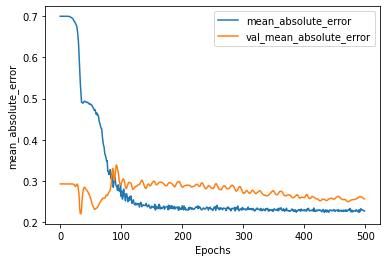

In [36]:
def plot_history(history, key):
    plt.plot(history.history[key])
    plt.plot(history.history['val_'+key])
    plt.xlabel("Epochs")
    plt.ylabel(key)
    plt.legend([key, 'val_'+key])
    plt.show()
    
# Plot the history
plot_history(history, 'mean_absolute_error')

In [48]:
print('Train:')
r=print_evaluate(y_train, model.predict(X_train_shaped))
print('\nTest:')
s=print_evaluate(y_test, model.predict(X_test_shaped))

save_results('Neural network (target = inflation) ', r, s, 2, True)

Train:
R-squared: 0.27337
MSE: 0.699
RMSE: 0.836
MAE: 0.224

Test:
R-squared: -1.87515
MSE: 0.14
RMSE: 0.375
MAE: 0.283


### 4.2 target = dollar

In [52]:
np.random.seed(seed)
# loss function
model.compile(
    loss='mean_absolute_error', 
    optimizer=Adam(learning_rate=0.002), 
    metrics=['mean_absolute_error']
)

# train the model
history = model.fit(
    X_train_shaped, 
    y_train2.values, 
    epochs=500, 
    batch_size=7,
    validation_data=(X_test_shaped, y_test2.values)
)


Epoch 1/500
1/1 [==============================] - 1s 740ms/step - loss: 0.8615 - mean_absolute_error: 0.8615 - val_loss: 0.8571 - val_mean_absolute_error: 0.8571
Epoch 2/500
1/1 [==============================] - 0s 35ms/step - loss: 0.8615 - mean_absolute_error: 0.8615 - val_loss: 0.8571 - val_mean_absolute_error: 0.8571
Epoch 3/500
1/1 [==============================] - 0s 37ms/step - loss: 0.8615 - mean_absolute_error: 0.8615 - val_loss: 0.8571 - val_mean_absolute_error: 0.8571
Epoch 4/500
1/1 [==============================] - 0s 46ms/step - loss: 0.8615 - mean_absolute_error: 0.8615 - val_loss: 0.8571 - val_mean_absolute_error: 0.8571
Epoch 5/500
1/1 [==============================] - 0s 44ms/step - loss: 0.8615 - mean_absolute_error: 0.8615 - val_loss: 0.8571 - val_mean_absolute_error: 0.8571
Epoch 6/500
1/1 [==============================] - 0s 42ms/step - loss: 0.8615 - mean_absolute_error: 0.8615 - val_loss: 0.8571 - val_mean_absolute_error: 0.8571
Epoch 7/500
1/1 [==========

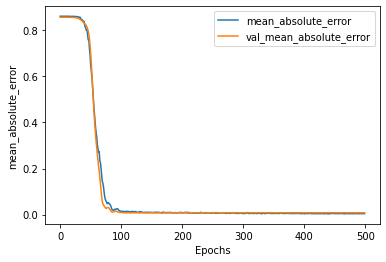

In [53]:
# Plot the history
plot_history(history, 'mean_absolute_error')

In [54]:
print('Train:')
r=print_evaluate(y_train2, model.predict(X_train_shaped))
print('\nTest:')
s=print_evaluate(y_test2, model.predict(X_test_shaped))

save_results('Neural network (target = dollar exchange rate)', r, s, 2)

Train:
R-squared: 0.89829
MSE: 0.0
RMSE: 0.008
MAE: 0.005

Test:
R-squared: 0.68667
MSE: 0.0
RMSE: 0.008
MAE: 0.008


In [277]:
create_df(2)

,r2_Train,r2_Test,MSE_Train,MSE_Test,RMSE_Train,RMSE_Test,MAE_Train,MAE_Test
Neural network (target = inflation),0.273372,-1.875154,0.699424,0.140384,0.836316,0.374678,0.224131,0.283316
Neural network (target = dollar exchange rate),0.898291,0.686669,0.000057,0.000071,0.007546,0.008413,0.004671,0.007577


As a result, when targent is changes in inflation, neural network models failed to outperform  RFE with XGBoost regression. This might be due to the high dimensionality and sparse characteristics of the textual data.  But our Neural Network performs better than RFE with XGBoost regressior model when target is dollar exchange rate. 